In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/data.zip","r")
zip_ref.extractall("/content/")
zip_ref.close()

In [7]:
!pip install split-folders

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
import math
import random
import os

In [11]:
# count the number of images in the respective classes 1 - tumor and 0 - Normal
ROOT_DIR ="/content/data/"

In [12]:
splitfolders.ratio(ROOT_DIR,output="splited_data",
                   seed=42,
                   ratio=(.7,.0,.3),
                   group_prefix=None)

Copying files: 7360 files [00:03, 2155.79 files/s]


In [16]:
# generators
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/splited_data/train/",
    labels = "inferred",
    label_mode ="int",
    batch_size=64,
    image_size=(256,256)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="/content/splited_data/test/",
    labels = "inferred",
    label_mode ="int",
    batch_size=64,
    image_size=(256,256)
)

Found 5151 files belonging to 2 classes.
Found 2209 files belonging to 2 classes.


In [21]:
# Normalize
def process(image,label):
  image = tf.cast(image/255.,tf.float32)
  return image,label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [22]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [23]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [24]:
# Path to the folders containing the images
normal_folder = '/content/splited_data/train/Normal'
tumor_folder = '/content/splited_data/train/Tumor'

# Get the list of image filenames in the folders
normal_images = [os.path.join(normal_folder, filename) for filename in os.listdir(normal_folder)]
tumor_images = [os.path.join(tumor_folder, filename) for filename in os.listdir(tumor_folder)]

# Combine the lists of images
all_images = normal_images + tumor_images
random.shuffle(all_images)  # Shuffle the images

In [25]:
# Function to plot images
def plotImages(image_paths):
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    for img_path, ax in zip(image_paths, axes.ravel()):
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(os.path.basename(os.path.dirname(img_path)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

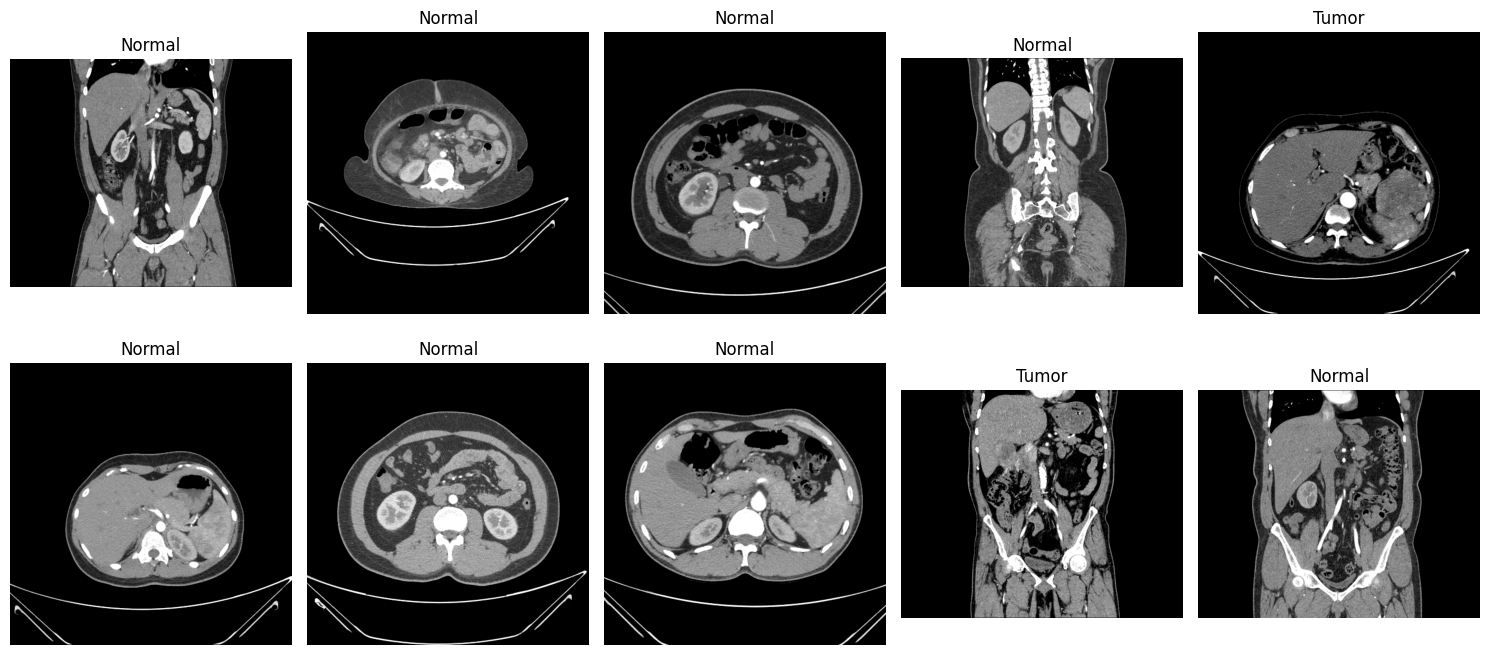

In [26]:
# Select 10 random images
selected_images = random.sample(all_images, 10)

# Plot the selected images
plotImages(selected_images)

Network with attention

In [27]:
# Create the model
simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=(256,256,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
simple_cnn_with_attention.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [29]:
# Print the model summary
simple_cnn_with_attention.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 channel_attention (ChannelA  (None, 256, 256, 32)     0         
 ttention)                                                       
                                                        

In [31]:
# Train the model
history = simple_cnn_with_attention.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50
81/81 [==============================] - 46s 519ms/step - loss: 0.2719 - accuracy: 0.8785 - precision: 0.8231 - recall: 0.7747 - val_loss: 1.1424 - val_accuracy: 0.3101 - val_precision: 0.3101 - val_recall: 1.0000
Epoch 2/50
81/81 [==============================] - 44s 527ms/step - loss: 0.1930 - accuracy: 0.9181 - precision: 0.8755 - recall: 0.8579 - val_loss: 3.9447 - val_accuracy: 0.3101 - val_precision: 0.3101 - val_recall: 1.0000
Epoch 3/50
81/81 [==============================] - 44s 530ms/step - loss: 0.1033 - accuracy: 0.9631 - precision: 0.9484 - recall: 0.9318 - val_loss: 9.1467 - val_accuracy: 0.3101 - val_precision: 0.3101 - val_recall: 1.0000


KeyboardInterrupt: ignored

In [ ]:
# Save the model
model_save_path = './model/simple_cnn_with_attention.h5'
simple_cnn_with_attention.save(model_save_path)

In [ ]:
plt.plot(history.history["accuracy"],color="red",label="train")
plt.plot(history.history['val_accuracy'],color="blue",label="validation")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history["loss"],color="red",label="train")
plt.plot(history.history['val_loss'],color="blue",label="validation")
plt.legend()
plt.show()

In [ ]:
# Load the saved model
model_path = 'simple_cnn_with_attention.h5'
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
import cv2
# test_img =cv2.imread("/content/splited_data/Normal/Normal- (101).jpg")
# test_img =cv2.imread("/content/splited_data/Tumor/Tumor- (108).jpg")

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

In [ ]:
test_img = cv2.resize(test_img,(256,256))

In [ ]:
test_input =test_img.reshape((1,256,256,3))

In [ ]:
loaded_model.predict(test_input)